In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import matplotlib.pyplot as plt
import time
%matplotlib inline

def generateGaussRandom(numberOfPaths, pathLength, mySeed):
    #GenerateGaussRandom
    if mySeed:
        np.random.seed(mySeed)
    N = numberOfPaths*pathLength
    W = np.random.normal(0.0,1.0,N)
    W = W.reshape((numberOfPaths,pathLength))
    return W
    
def generateGBMPaths(W,numberOfPaths,pathLength,dt,S0=100,mu=0.0,vol=0.2):
    T  = pathLength*dt
    ST = []
    sqrtDt = np.sqrt(dt)
    for path in np.arange(numberOfPaths):
        st = S0
        for timeStep in np.arange(pathLength):
            st = st * (1 + rfr*dt + vol*sqrtDt*W[path,timeStep])
        ST.append(st)
    ST = np.array(ST)
    #print('ST:',np.mean(ST), np.std(ST),'    -     ',S0*np.exp(mu*T), np.sqrt(S0**2*np.exp(2*mu*T)*(np.exp(vol**2*T)-1)))
    return ST

def getPayoff(ST,K,oType):
    if   oType == 'Call':
        payoff = np.maximum(ST-K,0)
    elif oType == 'Put':
        payoff = np.maximum(K-ST,0)
    else:
        pass
    return payoff

def bsMCPricer(S0,K,t2m,rfr,vol,numberOfPaths,pathLength,oType,mySeed,calcGreeks):
    dt = t2m/pathLength
    W  = generateGaussRandom(numberOfPaths,pathLength,mySeed)
    ST = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0,rfr,vol)
    # discounted expected payoff under Q-meassure
    payoff = getPayoff(ST,K,oType)
    price = np.exp(-rfr*t2m)*np.mean(payoff)
    
    if calcGreeks:
        eps = 0.005
        STSUP     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0*(1+eps),rfr,vol)
        payoffSUP = getPayoff(STSUP,K,oType)
        priceSUP  = np.exp(-rfr*t2m)*np.mean(payoffSUP)
        STSDN     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0*(1-eps),rfr,vol)
        payoffSDN = getPayoff(STSDN,K,oType)
        priceSDN  = np.exp(-rfr*t2m)*np.mean(payoffSDN)
        delta     = np.subtract(priceSUP,priceSDN)/(2*eps*S0)
        gamma     = np.add(np.subtract(priceSUP,2*price),priceSDN)/((eps*S0)**2)

        eps = 0.001
        STVolUP     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0,rfr,vol*(1+eps))
        payoffVolUP = getPayoff(STVolUP,K,oType)
        priceVolUP  = np.exp(-rfr*t2m)*np.mean(payoffVolUP)
        STVolDN     = generateGBMPaths(W,numberOfPaths,pathLength,dt,S0,rfr,vol*(1-eps))
        payoffVolDN = getPayoff(STVolDN,K,oType)
        priceVolDN  = np.exp(-rfr*t2m)*np.mean(payoffVolDN)
        vega        = np.subtract(priceVolUP,priceVolDN)/(2*eps*vol)

        
        return {'price':price, 'delta':delta, 'gamma':gamma, 'vega':vega}
    else:
        delta     = None
        return price

Calculate Price and Greeks of a single PV option

In [2]:
pathLength    = 12
numberOfPaths = 10000

S0         = 100
K          = 100
t2m        = 1.0
rfr        = 0.05
vol        = 0.2
oType      = 'Call'
mySeed     = None
calcGreeks = True

price    = bsMCPricer(S0,K,t2m,rfr,vol,numberOfPaths,pathLength,oType,mySeed,calcGreeks)
print(price)

{'price': 10.573847898074732, 'delta': 0.6429680526990929, 'gamma': 0.019593417164870175, 'vega': 38.397754437276}


Calculate Price and Greeks of a range of PV option

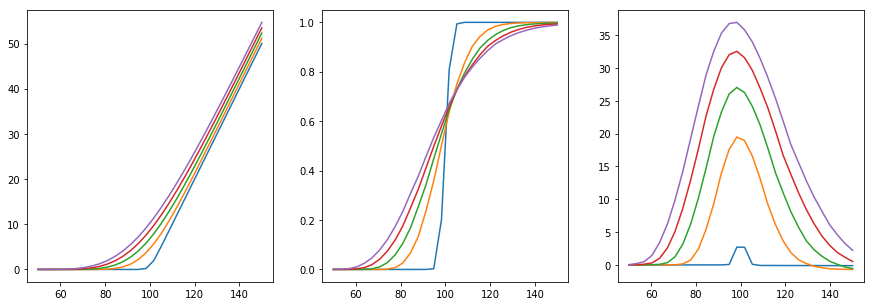

In [3]:
pathLength    = 12
numberOfPaths = 10000

S0         = 100
K          = 100
t2m        = 1.0
rfr        = 0.05
vol        = 0.2
oType      = 'Call'
mySeed     = 15  #None
calcGreeks = True

parameterRange1 = np.linspace(0.5*K,1.5*K,30)
parameterRange2 = np.linspace(0.01,1.0,5)
resultRangeA    = []
resultRangeB    = []
resultRangeC    = []
for y in parameterRange2:
    tmpResultRangeA = []
    tmpResultRangeB = []
    tmpResultRangeC = []
    for x in parameterRange1:
        S0  = x
        t2m = y
        output = bsMCPricer(S0,K,t2m,rfr,vol,numberOfPaths,pathLength,oType,mySeed,calcGreeks)
        tmpResultRangeA.append(output['price'])
        tmpResultRangeB.append(output['delta'])
        tmpResultRangeC.append(output['vega'])
    resultRangeA.append(tmpResultRangeA)
    resultRangeB.append(tmpResultRangeB)
    resultRangeC.append(tmpResultRangeC)

fig = plt.figure(figsize = (15,5))

ax1  = plt.subplot(1,3,1)
for result in resultRangeA:
    ax1 = plt.plot(parameterRange1, result)

ax2  = plt.subplot(1,3,2)
for result in resultRangeB:
    ax2 = plt.plot(parameterRange1, result)
    
ax3  = plt.subplot(1,3,3)
for result in resultRangeC:
    ax3 = plt.plot(parameterRange1, result)

MonteCarlo convergence test

In [4]:
pathLength        = 12
numberOfEnsembles = 20

S0         = 100
K          = 100
t2m        = 1.0
rfr        = 0.05
vol        = 0.2
oType      = 'Call'
mySeed     = None
calcGreeks = False

convergenceTest = []
for pwr in [8,9,10,11,12,13,14,15,16,17]:
    nOP = 2**pwr
    startTime = time.time()
    print(nOP,end='   -   ')
    ens = []
    for e in np.arange(numberOfEnsembles):
        price = bsMCPricer(S0,K,t2m,rfr,vol,nOP,pathLength,oType,mySeed,calcGreeks)
        ens.append(price)
    
    mean = np.mean(ens)
    std = np.std(ens)
    endTime = time.time()
    runTime = endTime - startTime
    print(runTime,'sec',' -> ',mean, std)
    convergenceTest.append([nOP,mean,std,runTime])

convergenceTest = np.array(convergenceTest)    
print(convergenceTest)

256   -   0.07606887817382812 sec  ->  10.12132807766984 0.6853732938607997
512   -   0.1317307949066162 sec  ->  10.541081093405957 0.6846153307520817
1024   -   0.2504899501800537 sec  ->  10.407289478044188 0.37696203949636964
2048   -   0.5049858093261719 sec  ->  10.516242459931464 0.2737044332796519
4096   -   1.001645803451538 sec  ->  10.487067567215831 0.24952424307817384
8192   -   2.032886028289795 sec  ->  10.384342692341523 0.15900791221476002
16384   -   4.012976169586182 sec  ->  10.441907937158494 0.11187024179944705
32768   -   7.9335761070251465 sec  ->  10.461014470895792 0.06187162621770839
65536   -   16.41992211341858 sec  ->  10.429786802263585 0.06472836078863835
131072   -   31.5317120552063 sec  ->  10.449541380375766 0.04547459201917169
[[2.56000000e+02 1.01213281e+01 6.85373294e-01 7.60688782e-02]
 [5.12000000e+02 1.05410811e+01 6.84615331e-01 1.31730795e-01]
 [1.02400000e+03 1.04072895e+01 3.76962039e-01 2.50489950e-01]
 [2.04800000e+03 1.05162425e+01 2.737

Display convergence test results

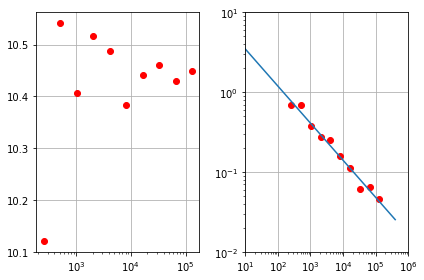

slope:  [-0.46425084  2.31679958]


In [6]:
plt.subplot(121)
plt.semilogx(convergenceTest[:,0],convergenceTest[:,1], 'ro')
plt.grid(True)

fit = np.polyfit(np.log(convergenceTest[:,0]),np.log(convergenceTest[:,2]),1)
xfit = np.linspace(0.001,4*10**5,3)
yfit = np.power(xfit,fit[0])*np.exp(fit[1])
plt.subplot(122)
plt.loglog(convergenceTest[:,0],convergenceTest[:,2], 'ro')
plt.loglog(xfit,yfit)

plt.grid(True)
plt.xlim(10, 1000000)
plt.ylim(0.01, 10)

plt.tight_layout()
plt.show()

print('slope: ', fit)